# Cross validation and modelling

# Module import

In [54]:
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, average_precision_score, f1_score

# cross-validation after feature selection
# please change loading path before running
- K-fold (3)
- still look at AUC under PR due to imbalanced data

# Load data
- if woe_run = True, it will load woe transformed related preprocessed data

- if woe_run = False, it will load preprocessed data (T1) without woe transformed

In [55]:
woe_run = False

In [62]:
if woe_run:
    data = pickle.load(open( "./woe_data_model/processed_data_woe.p", "rb" ) )
else:
    data = pickle.load(open( "./processed_data_T1.p", "rb" ) )

X = data["X"]
y = data["y"]

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,24,2,2,-1,-1,-2,-2,3913,3102,...,1,0,0,1,0,0,0,1,0,0
2,120000,26,-1,2,0,0,0,2,2682,1725,...,1,0,0,1,0,0,0,0,1,0
3,90000,34,0,0,0,0,0,0,29239,14027,...,1,0,0,1,0,0,0,0,1,0
4,50000,37,0,0,0,0,0,0,46990,48233,...,1,0,0,1,0,0,0,1,0,0
5,50000,57,-1,0,-1,0,0,0,8617,5670,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,220000,39,0,0,0,0,0,0,188948,192815,...,0,0,0,0,1,0,0,1,0,0
29997,150000,43,-1,-1,-1,-1,0,0,1683,1828,...,0,0,0,0,1,0,0,0,1,0
29998,30000,37,4,3,2,-1,0,0,3565,3356,...,0,0,0,1,0,0,0,0,1,0


# Train test split
data were split into two set (70%/30%).

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 10, stratify=y)

# Cross validation

## param_grid
- this cross-validation was run using param_grid1 firstly
- some variables reached the boundary settings in the first cross-validation using param_grid1
- param_grid2 was defined to adjust the boundary to search again to ensure the reliability

In [6]:
# grid data to search
param_grid1 = {
    'max_depth': [6, 9, 12],
    'learning_rate':[0.01, 0.1, 0.9],
    'gamma': [0, 0.5, 1],
    'reg_lambda': [0, 5, 10],
    'scale_pos_weight': [3, 9]
}

In [7]:
param_grid2 = {
    'max_depth': [6],
    'learning_rate':[0.1],
    'gamma': [0],
    'reg_lambda': [10, 20, 30],
    'scale_pos_weight': [3]
}

# GridSearchCV
please check the param_grid in the argument to make sure the correct param grid is used.

In [19]:
optimal_params = GridSearchCV(estimator = xgb.XGBClassifier(objective="binary:logistic", 
                                                            random_state = 10, 
                                                            subsample=0.8,
                                                            colsample_bytree=0.8, 
                                                            use_label_encoder=False),
                              param_grid=param_grid2,
                             scoring="average_precision",cv=3, verbose=2, n_jobs=5)
optimal_params.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[13:42:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=10,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=0.8,
                                     tree_method=None, use

In [8]:
optimal_params.best_params_

NameError: name 'optimal_params' is not defined

In [21]:
optimal_params.best_score_

0.5564979745462204

# Save parameters
- without woe: T1 processed data -> ./cv_optimal_params_with_paramgrid2.p
- with woe: woe processed data -> ./woe_data_model/cv_optimal_params_with_paramgrid2.p

# best params save


In [22]:
# pickle.dump( {"optimal_params": optimal_params}, open( "./woe_data_model/cv_optimal_params_with_paramgrid2.p", "wb" ) )

# Model fit
use the best hyperparameters and all the data in training set to fit the mdoel again

In [64]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state = 10, 
                                                             gamma = 1,
                                                          reg_lambda = 10,
                                                            max_depth = 6,
                                                      scale_pos_weight = 9,
                                                       learning_rate = 0.1,
                                                       colsample_bytree=0.8,subsample=0.8,
                              
                                                            use_label_encoder=False)

In [65]:
xgb_model.fit(X_train, y_train, verbose=True, early_stopping_rounds = 10, eval_metric="aucpr",eval_set=[(X_test,y_test)])

[0]	validation_0-aucpr:0.51242
[1]	validation_0-aucpr:0.52065
[2]	validation_0-aucpr:0.52280
[3]	validation_0-aucpr:0.52411
[4]	validation_0-aucpr:0.52612
[5]	validation_0-aucpr:0.54052
[6]	validation_0-aucpr:0.54129
[7]	validation_0-aucpr:0.54234
[8]	validation_0-aucpr:0.54164
[9]	validation_0-aucpr:0.54345
[10]	validation_0-aucpr:0.54236
[11]	validation_0-aucpr:0.54304
[12]	validation_0-aucpr:0.54154
[13]	validation_0-aucpr:0.54330
[14]	validation_0-aucpr:0.54234
[15]	validation_0-aucpr:0.54367
[16]	validation_0-aucpr:0.54265
[17]	validation_0-aucpr:0.54385
[18]	validation_0-aucpr:0.54456
[19]	validation_0-aucpr:0.54534
[20]	validation_0-aucpr:0.54456
[21]	validation_0-aucpr:0.54450
[22]	validation_0-aucpr:0.54610
[23]	validation_0-aucpr:0.54654
[24]	validation_0-aucpr:0.54584
[25]	validation_0-aucpr:0.54583
[26]	validation_0-aucpr:0.54533
[27]	validation_0-aucpr:0.54671
[28]	validation_0-aucpr:0.54666
[29]	validation_0-aucpr:0.54724
[30]	validation_0-aucpr:0.54609
[31]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=10,
              reg_alpha=0, reg_lambda=10, scale_pos_weight=9, subsample=0.8,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

# Test

In [66]:
y_pred = xgb_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
recall_val = cm[1,1] / (cm[1,0]+cm[1,1])
y_prob = xgb_model.predict_proba(X_test)
average_precision_score(y_test, y_prob[:,1])

0.5502431743045912

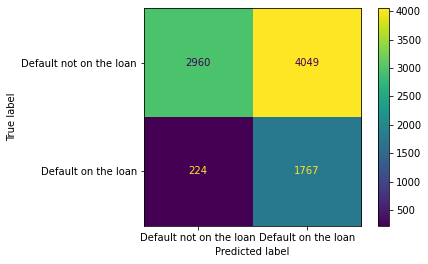

In [67]:
plot_confusion_matrix(xgb_model, X_test,y_test, display_labels=["Default not on the loan", "Default on the loan"])

# Save fitted model
without woe: T1 processed model : "./model_cv_xgb.p"

with woe -> woe processed model "./woe_data_model/model_woe_xgb.p"

In [68]:
pickle.dump({"xgb_model": xgb_model}, open( "./model_cv_xgb.p", "wb" ) )

# Results
- without woe: T1 processed model -> aucpr 0.5502431743045912, recall 0.8874937217478654

- with woe: woe processed model -> aucpr 0.5570952700328535, recall 0.903566047212456

# Predict
